In [1]:
#importing the dependencies
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import ensemble
import time
import numpy as np
from sklearn.svm import SVC
import pandas as pd
from collections import Counter
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB,_BaseNB
import seaborn as sn

In [2]:
#faster training
from sklearnex import patch_sklearn
patch_sklearn()
#10 to 100x fast

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
#Load the data
lfw=datasets.fetch_lfw_people(min_faces_per_person=100,resize=0.5)

In [4]:
lfw.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [5]:
lfw.data.shape

(1140, 2914)

In [6]:
lfw.images.shape
imtotal,imx,imy=lfw.images.shape
print(imtotal,imx,imy)

1140 62 47


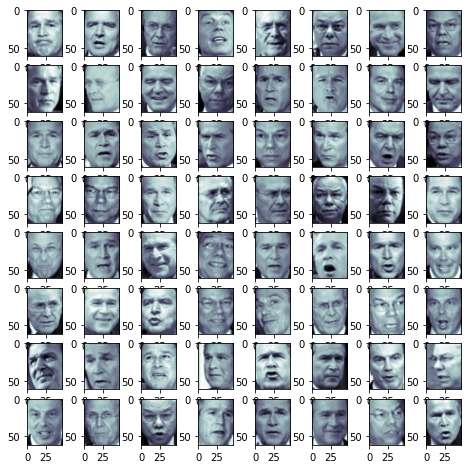

In [7]:
#plot the figures
fig=plt.figure(figsize=(8,8))
for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    ax.imshow(lfw.images[i],cmap=plt.cm.bone) 

In [8]:
x,y=lfw.data,lfw.target

In [9]:
print(imblearn.__version__)

0.7.0


In [10]:
#split the data for training and testing
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0)

In [11]:
x_train.shape,x_test.shape,x.shape

((855, 2914), (285, 2914), (1140, 2914))

In [12]:
#PCA instance for checking how many features to take 
pca_check=PCA()
pca_check.fit(x_train)

PCA()

In [13]:
#check upto how many features a defined explained variance is reached
k=0
currsum=0
while currsum<0.90:  #for 90%
    currsum+=pca_check.explained_variance_ratio_[k]
    k+=1
k

78

In [14]:
pca_lwf=PCA(n_components=k,whiten=True)
#whiten does normalization (removes the relative variance scales of the components)
#Accuracy Score : 91.22% -> 91.57% by using whiten=True (SVC with PCA score)

In [15]:
x_train.shape

(855, 2914)

In [16]:
# len(x_train)

In [17]:
# clf=ensemble.RandomForestClassifier()
# grid={"max_leaf_nodes":list(np.arange(10,300))}
# gscv=GridSearchCV(clf,grid)
# gscv.fit(x_train,y_train)
# gscv.best_estimator_

In [18]:
# gscv.best_score_

In [19]:
# gscv.cv_results_

In [20]:
# clf=SVC()
# grid={"gamma":[.01,.1,1,10,100],"C":[.01,.1,1,10,100]}
# gscv=GridSearchCV(clf,grid)
# gscv.fit(x_train,y_train)
# gscv.best_estimator_

In [21]:
# gscv.best_score_

In [22]:
# gscv.cv_results_


In [23]:
#Print count of various y values
print(sorted(Counter(y).items() ))
print(sorted(Counter(y_train).items() ))
print(sorted(Counter(y_test).items() ))

[(0, 236), (1, 121), (2, 530), (3, 109), (4, 144)]
[(0, 175), (1, 85), (2, 408), (3, 78), (4, 109)]
[(0, 61), (1, 36), (2, 122), (3, 31), (4, 35)]


In [24]:
#oversampling the train data for every non majority class
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy="not majority")
x_train,y_train=oversample.fit_resample(x_train,y_train)

print(sorted(Counter(y_train).items() ))

[(0, 408), (1, 408), (2, 408), (3, 408), (4, 408)]


In [25]:
#Apply PCA on oversampled data
x_transformed=pca_lwf.fit_transform(x_train)

In [26]:
pca_lwf.n_components

78

In [27]:
x_transformed.shape

(2040, 78)

### Visualize approx data of faces ( generated by PCA tranform )

In [28]:
x_approx=pca_lwf.inverse_transform(x_transformed)
x_approx=x_approx.reshape((len(x_train),imx,imy))

In [29]:
x_approx.shape

(2040, 62, 47)

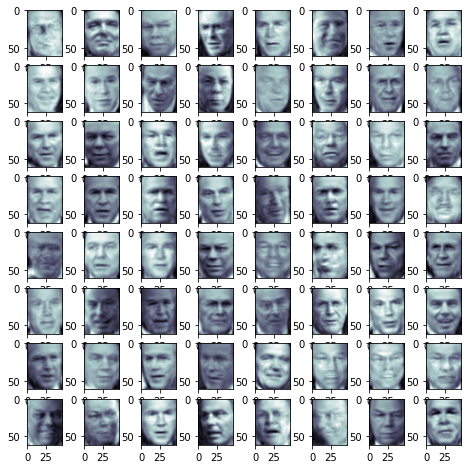

In [30]:
#Plot approx faces
fig=plt.figure(figsize=(8,8))
for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    plt.imshow(x_approx[i],cmap=plt.cm.bone)
plt.show()

### Visualize Eigenfaces/Eigenvectors

In [31]:
eigen=pca_lwf.components_
eigen_faces=eigen.reshape((eigen.shape[0],imx,imy))

In [32]:
eigen.shape

(78, 2914)

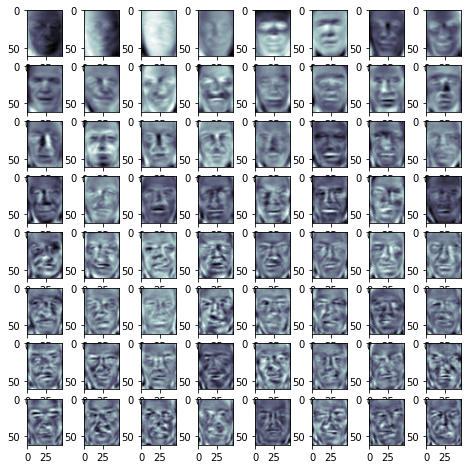

In [33]:
#Plot eigenfaces
fig=plt.figure(figsize=(8,8))
for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    plt.imshow(eigen_faces[i],cmap=plt.cm.bone)
plt.show()

In [34]:
#Renaming training data
x_train_pca=x_transformed
#Tranforming testing data
x_test_pca=pca_lwf.transform(x_test)
#stores scores of every algorithm
all_scores=[]

## Apply ML Algorithms

## Random Forest

Time taken =  0.2049567699432373
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        61
           1       0.89      0.47      0.62        36
           2       0.73      0.98      0.84       122
           3       0.89      0.55      0.68        31
           4       0.84      0.46      0.59        35

    accuracy                           0.78       285
   macro avg       0.83      0.66      0.71       285
weighted avg       0.80      0.78      0.76       285



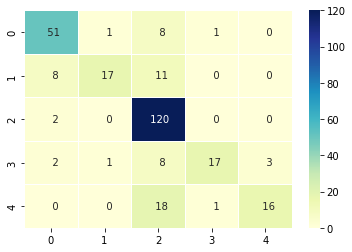

In [35]:
#without PCA 
rf=ensemble.RandomForestClassifier(max_leaf_nodes=137,random_state=0)
start=time.time()
rf.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=rf.predict(x_test)
print(classification_report(y_test,y_pred))
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

Time taken =  0.483295202255249
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        61
           1       0.94      0.42      0.58        36
           2       0.71      0.97      0.82       122
           3       0.88      0.45      0.60        31
           4       0.76      0.54      0.63        35

    accuracy                           0.75       285
   macro avg       0.81      0.63      0.68       285
weighted avg       0.77      0.75      0.73       285



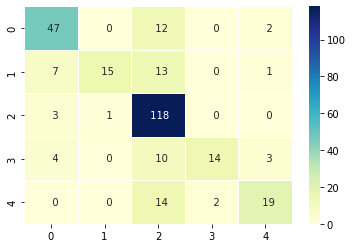

In [36]:
#with PCA
rf_pca=ensemble.RandomForestClassifier(max_leaf_nodes=137,random_state=0)
start=time.time()
rf_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=rf_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

In [37]:
print(rf_pca.score(x_train_pca,y_train),rf_pca.score(x_test_pca,y_test))

non_pca_score=rf.score(x_test,y_test)
pca_score=rf_pca.score(x_test_pca,y_test)
all_scores.append(["Random Forest :",non_pca_score,pca_score])
print(non_pca_score,pca_score)

1.0 0.7473684210526316
0.775438596491228 0.7473684210526316


## SVC


Time taken =  2.136124849319458
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        61
           1       0.90      0.78      0.84        36
           2       0.89      0.97      0.93       122
           3       0.93      0.81      0.86        31
           4       0.93      0.80      0.86        35

    accuracy                           0.90       285
   macro avg       0.91      0.86      0.88       285
weighted avg       0.90      0.90      0.90       285



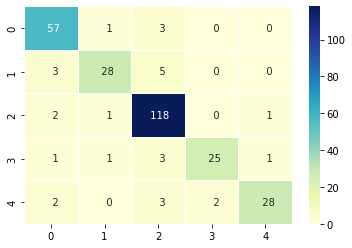

In [38]:
#without PCA
svc=SVC()
start=time.time()
svc.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=svc.predict(x_test)
print(classification_report(y_test,y_pred))
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

In [39]:
print(svc.score(x_train,y_train),svc.score(x_test,y_test))

0.9950980392156863 0.8982456140350877


Time taken =  0.09667658805847168
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        61
           1       0.97      0.81      0.88        36
           2       0.88      0.98      0.93       122
           3       0.96      0.77      0.86        31
           4       0.94      0.83      0.88        35

    accuracy                           0.92       285
   macro avg       0.94      0.87      0.90       285
weighted avg       0.92      0.92      0.91       285



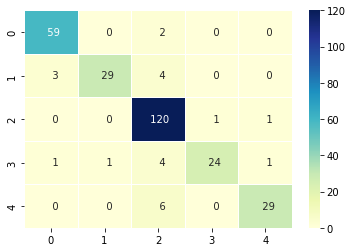

In [40]:
#with PCA
svc_pca=SVC()
start=time.time()
svc_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=svc_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

In [41]:
print(svc_pca.score(x_train_pca,y_train),svc_pca.score(x_test_pca,y_test))

non_pca_score=svc.score(x_test,y_test)
pca_score=svc_pca.score(x_test_pca,y_test)
all_scores.append(["Support Vector Classifier :",non_pca_score,pca_score])
print(non_pca_score,pca_score)

0.9985294117647059 0.9157894736842105
0.8982456140350877 0.9157894736842105


## Logistic Regression

Time taken =  0.6822271347045898
              precision    recall  f1-score   support

           0       0.85      0.82      0.83        61
           1       0.76      0.81      0.78        36
           2       0.87      0.92      0.89       122
           3       0.85      0.71      0.77        31
           4       0.88      0.83      0.85        35

    accuracy                           0.85       285
   macro avg       0.84      0.82      0.83       285
weighted avg       0.85      0.85      0.85       285



c:\Users\Dell\anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


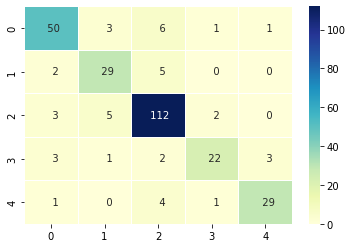

In [42]:
#without PCA
lr=LogisticRegression()
start=time.time()
lr.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=lr.predict(x_test)
print(classification_report(y_test,y_pred))
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

Time taken =  0.014496088027954102
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        61
           1       0.87      0.72      0.79        36
           2       0.87      0.89      0.88       122
           3       0.75      0.68      0.71        31
           4       0.76      0.83      0.79        35

    accuracy                           0.84       285
   macro avg       0.82      0.80      0.80       285
weighted avg       0.84      0.84      0.83       285



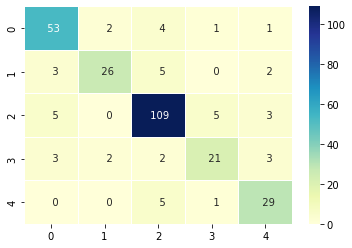

In [43]:
#with PCA
lr_pca=LogisticRegression()
start=time.time()
lr_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=lr_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

In [44]:
print(lr_pca.score(x_train_pca,y_train),lr_pca.score(x_test_pca,y_test))

non_pca_score=lr.score(x_test,y_test)
pca_score=lr_pca.score(x_test_pca,y_test)
all_scores.append(["Logistic Regression :",non_pca_score,pca_score])
print(non_pca_score,pca_score)

0.9779411764705882 0.8350877192982457
0.8491228070175438 0.8350877192982457


## Naive Bayes

Time taken =  0.037873268127441406
              precision    recall  f1-score   support

           0       0.40      0.57      0.47        61
           1       0.45      0.53      0.49        36
           2       0.77      0.61      0.68       122
           3       0.48      0.32      0.38        31
           4       0.55      0.60      0.58        35

    accuracy                           0.56       285
   macro avg       0.53      0.53      0.52       285
weighted avg       0.59      0.56      0.57       285



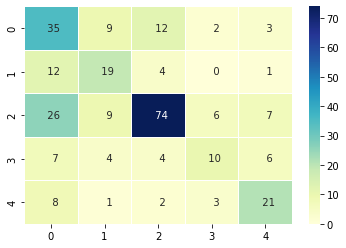

In [45]:
#without PCA
gnb=GaussianNB()
start=time.time()
gnb.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=gnb.predict(x_test)
print(classification_report(y_test,y_pred))
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")


Time taken =  0.0019850730895996094
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        61
           1       0.78      0.78      0.78        36
           2       0.86      0.89      0.87       122
           3       0.69      0.65      0.67        31
           4       0.79      0.66      0.72        35

    accuracy                           0.82       285
   macro avg       0.79      0.77      0.78       285
weighted avg       0.82      0.82      0.82       285



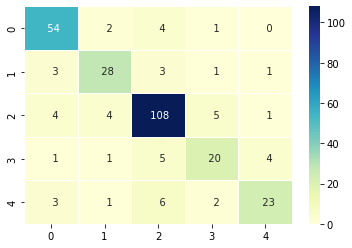

In [46]:
#with PCA
gnb_pca=GaussianNB()
start=time.time()
gnb_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=gnb_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")


In [47]:
print(gnb_pca.score(x_train_pca,y_train),gnb_pca.score(x_test_pca,y_test))

non_pca_score=gnb.score(x_test,y_test)
pca_score=gnb_pca.score(x_test_pca,y_test)
all_scores.append(["Gaussian Naive Bayes :",non_pca_score,pca_score])

0.8794117647058823 0.8175438596491228


### Tabulate scores of all the algorithms

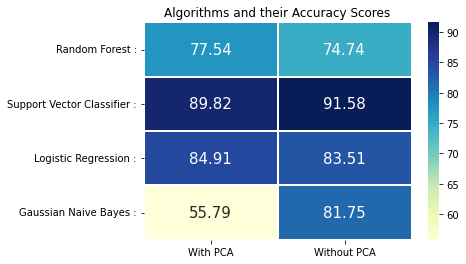

In [48]:
import copy
# print(pd.DataFrame(all_scores,columns={"Algorithms","Without PCA","With PCA"} ))
l=copy.deepcopy(all_scores)
data=np.array([rw[1:]for rw in l])*100
plt.title("Algorithms and their Accuracy Scores")
ax=sn.heatmap(data,annot=True,linewidths=1.7,fmt="4.4",cmap="YlGnBu",xticklabels={"Without PCA","With PCA"},yticklabels=list([rw[0] for rw in l]),annot_kws={'size':15})